## Objective: Using LSTM to predict whether the movie review is positive or negative.

In [1]:
from tensorflow import keras
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, LSTM, Embedding, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

VOCAB_SIZE = 88584 
MAXLEN = 250    

In [2]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words = VOCAB_SIZE)

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [3]:
# define word_index & reverse_word_index

word_index = imdb.get_word_index() # get {word : index}

reverse_word_index = dict(
[(index, word) for (word, index) in word_index.items()]
)

1646592/1641221 [==============================] - 0s 0us/step


### Checking Starts

In [4]:
display(len(train_data), len(test_data), len(train_labels))
max([max(sequence) for sequence in train_data])

25000

25000

25000

88583

In [5]:
for j in range(3):
  print(j)
  print(' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[j]]))

0
? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should 

In [6]:
display(dict(list(word_index.items())[:3]))
dict(list(reverse_word_index.items())[:3])

{'fawn': 34701, 'nunnery': 52007, 'tsukino': 52006}

{34701: 'fawn', 52006: 'tsukino', 52007: 'nunnery'}

In [7]:
print(' '.join([reverse_word_index.get(i-3, '?') for i in train_data[0]]))
display(reverse_word_index.get(1))
display(reverse_word_index.get(34701))
display(word_index.get('this'))
display(reverse_word_index.get(11))

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be

'the'

'fawn'

11

'this'

In [8]:
display(len(train_data[0]))

np.reshape(train_data[0], (1,len(train_data[0])))

218

array([[    1,    14,    22,    16,    43,   530,   973,  1622,  1385,
           65,   458,  4468,    66,  3941,     4,   173,    36,   256,
            5,    25,   100,    43,   838,   112,    50,   670, 22665,
            9,    35,   480,   284,     5,   150,     4,   172,   112,
          167, 21631,   336,   385,    39,     4,   172,  4536,  1111,
           17,   546,    38,    13,   447,     4,   192,    50,    16,
            6,   147,  2025,    19,    14,    22,     4,  1920,  4613,
          469,     4,    22,    71,    87,    12,    16,    43,   530,
           38,    76,    15,    13,  1247,     4,    22,    17,   515,
           17,    12,    16,   626,    18, 19193,     5,    62,   386,
           12,     8,   316,     8,   106,     5,     4,  2223,  5244,
           16,   480,    66,  3785,    33,     4,   130,    12,    16,
           38,   619,     5,    25,   124,    51,    36,   135,    48,
           25,  1415,    33,     6,    22,    12,   215,    28,    77,
      

### Checking Ends

Fixing the comments' length in order to fit into the neural network 

In [9]:
train_data = sequence.pad_sequences(train_data, MAXLEN)
test_data = sequence.pad_sequences(test_data, MAXLEN)
train_data[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     1,    14,    22,    16,
          43,   530,   973,  1622,  1385,    65,   458,  4468,    66,
        3941,     4,   173,    36,   256,     5,    25,   100,    43,
         838,   112,    50,   670, 22665,     9,    35,   480,   284,
           5,   150,     4,   172,   112,   167, 21631,   336,   385,
          39,     4,   172,  4536,  1111,    17,   546,    38,    13,
         447,     4,   192,    50,    16,     6,   147,  2025,    19,
          14,    22,     4,  1920,  4613,   469,     4,    22,    71,
          87,    12,    16,    43,   530,    38,    76,    15,    13,
        1247,     4,    22,    17,   515,    17,    12,    16,   626,
          18, 19193,     5,    62,   386,    12,     8,   316,     8,
         106,     5,

### Creating the Model
Use a word embedding layer & a LSTM layer to feed into a dense node.

In [10]:
model = Sequential()
model.add(Embedding(VOCAB_SIZE,output_dim = 16, input_length = MAXLEN,  ))
model.add(LSTM(16, dropout= 0.5, recurrent_dropout = 0.5))
model.add(Dense(1, activation = 'sigmoid'))  

In [11]:
BATCH_SIZE = 32
model.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics=['acc'])

history = model.fit(train_data, train_labels, epochs=4, batch_size=BATCH_SIZE, validation_split=0.2, verbose = 1, shuffle = True)

Epoch 1/4
625/625 [==============================] - 249s 394ms/step - loss: 0.6105 - acc: 0.6400 - val_loss: 0.3832 - val_acc: 0.8540
Epoch 2/4
625/625 [==============================] - 245s 393ms/step - loss: 0.3243 - acc: 0.8715 - val_loss: 0.3266 - val_acc: 0.8818
Epoch 3/4
625/625 [==============================] - 245s 392ms/step - loss: 0.2504 - acc: 0.9048 - val_loss: 0.3880 - val_acc: 0.8748
Epoch 4/4
625/625 [==============================] - 245s 393ms/step - loss: 0.2080 - acc: 0.9257 - val_loss: 0.3081 - val_acc: 0.8850


### Check for overfitting: train_acc isn't way larger than val_acc, so let's proceed.

In [12]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

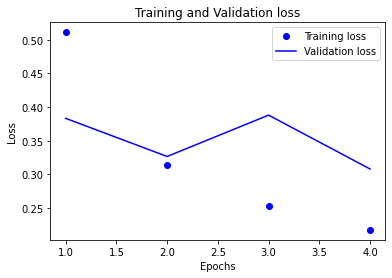

In [13]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

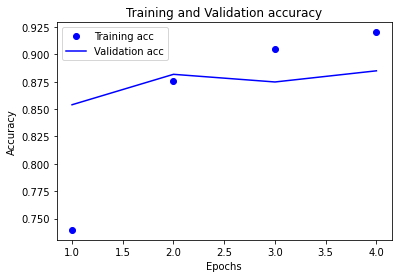

In [14]:
plt.clf()
acc = history_dict['acc']
val_acc = history_dict['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 16)           1417344   
_________________________________________________________________
lstm (LSTM)                  (None, 16)                2112      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 1,419,473
Trainable params: 1,419,473
Non-trainable params: 0
_________________________________________________________________


In [16]:
results = model.evaluate(test_data, test_labels)
print(results)
print('Loss is ' + '{:.3f}'.format(results[0]*100))
print('Accuracy is ', results[1]*100, '%')

782/782 [==============================] - 51s 65ms/step - loss: 0.3660 - acc: 0.8637
[0.3659655749797821, 0.8636800050735474]
Loss is 36.597
Accuracy is  86.36800050735474 %


In [17]:
print('{}   {}    {}'.format('Prediction', 'Label', 'Sentence'))
for j in range(3):
  idx = np.random.randint(len(test_data))
  xtest = test_data[idx].reshape(1,250)
  ylabel = test_labels[idx]
  ypred = model.predict(xtest)[0][0]
  sent = (' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[idx]]))
  print('{}             {}         {}'.format(int(round(ypred)),ylabel,sent))

Prediction   Label    Sentence
0             0         ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? i never really knew who robert wuhl was before seeing this but after seeing it i realized what a funny man he is this hbo special features him teaching american history to new york university film students and the man was just phenomenal he poked fun at almost every key historic event that occurred not just in the u s but some other parts of the world this documentary comedy was a great satire that made me question if what i accept as the infallible true history is really true br br i enjoyed how mr wuhl managed to mix useful information with great comedy and made learning a lot more exciting i would recommend this to anyone interested in history and is willing to question what his her beliefs
0 

In [18]:
outcome = model.predict(test_data)

In [19]:
import pandas as pd
df = pd.DataFrame(outcome)
df['Actual'] = test_labels

In [20]:
df.head(3)

,0,Actual
0,0.028895,0
1,0.985584,1
2,0.395207,1


confusion matrix [[11693  2601]
 [  807  9899]]
              precision    recall  f1-score   support

         0.0       0.94      0.82      0.87     14294
         1.0       0.79      0.92      0.85     10706

    accuracy                           0.86     25000
   macro avg       0.86      0.87      0.86     25000
weighted avg       0.87      0.86      0.86     25000



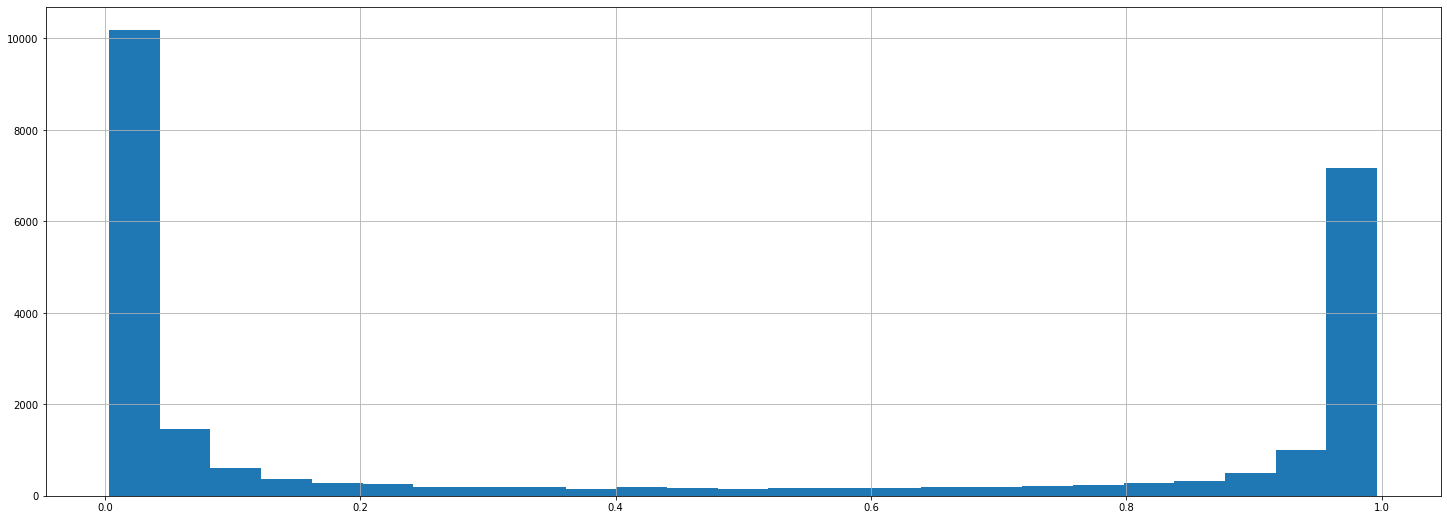

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
df.rename(columns = {0:'prediction'}, inplace=True)
df.prediction.hist(bins = 25, figsize = (25,9), )
print("confusion matrix",confusion_matrix(df.prediction.round(), df.Actual))
print(classification_report(df.prediction.round(), df.Actual))

Looking at the distribution, the model performed quite well with an 86% accuracy.

In [22]:
# encode function

word_index = imdb.get_word_index()

def encode_text(text):
  tokens = keras.preprocessing.text.text_to_word_sequence(text)
  tokens = [word_index[word] if word in word_index else 0 for word in tokens]
  return sequence.pad_sequences([tokens], MAXLEN)[0]

text = "It was an extremely exciting movie!"
encoded = encode_text(text)
print(encoded)

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

#### Let's try a few predictions

In [24]:
def predict(text):
  encoded_text = encode_text(text)
  pred = np.zeros((1,250))
  pred[0] = encoded_text
  result = model.predict(pred) 
  print(result[0])

In [25]:
review1 = "amazing movie, it's just so amazing amazing amazing amazing amazing amazing amazing"
predict(review1)

review2 = "That movie was crazy bad! I will not watch again"
predict(review2)

[0.6522331]
[0.43543726]


In [26]:
review3 = "That movie was awesome! I enjoyed watching it and it's worth to bring someone you love to watch together again."
predict(review3)

review4 = "that movie really disappointed me. I hated it and wouldn't watch it again. Was one of the worst things I've ever watched."

predict(review4)

[0.7226346]
[0.2231981]


### Reference

Chollet François. Deep Learning with Python. Manning Publications Co., 2018.